# I am using the cars1-2.dta Dataset. The code is reported in the blp_pset class. The results follows.

In [1]:
# load necessary packages python 
import pyblp
import numpy as np
import pandas as pd


In [2]:
# load data
data = pd.read_stata('../data/cars1-2.dta')

/opt/anaconda3/lib/python3.8/site-packages/pandas/io/stata.py:1417: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


In [3]:
data.columns

Index(['year', 'country', 'co', 'model', 'segment', 'domestic', 'firm',
       'brand', 'loc', 'qu', 'pr', 'princ', 'price', 'horsepower', 'fuel',
       'width', 'height', 'weight', 'pop', 'ngdp', 'ngdpe', 'country1',
       'country2', 'country3', 'country4', 'country5', 'yearsquared'],
      dtype='object')

In [4]:
class blp_pset:
    """
    A class used to represent a BLP (Berry, Levinsohn, and Pakes) model.
    Attributes
    ----------
    data : any
        The data used for the BLP model.
    Methods
    -------
    """
    def __init__(self, data):
        self.data = data
        

    def return_data(self):
        return self.data
    
    def define_market_share(self,market_share_assumption):
        # market share assumption
        # i will just assume total market share is a multiple of sales        
        # for each loc and year
        # first find total sale by adding up the qu
        
        data_copy = self.data.copy()
        data_copy['total_sales'] = data_copy.groupby(['country', 'year'])['qu'].transform('sum')
        # then calculate market share
        data_copy['market_share'] = data_copy['qu'] / (data_copy['total_sales'] * market_share_assumption)
        # then drop total_sales
        data_copy.drop(columns=['total_sales'], inplace=True)
        # define a outside share column
        data_copy['outside_share'] = 1 - data_copy.groupby(['country', 'year'])['market_share'].transform('sum')
        return data_copy
    
    def set_up_variables(self,dataset):
        # rename columns
        # market_ids = for each loc and year
        dataset['market_ids'] = dataset['country'].astype(str) + '_' + dataset['year'].astype(str)
        # product_ids = model
        dataset['product_ids'] = dataset['model']
        # shares =  market_share
        dataset['shares'] = dataset['market_share']
        # prices --> price
        dataset['prices'] = dataset['price']
        # firm_ids
        dataset['firm_ids'] = dataset['brand']

        return dataset
    
    def create_instruments(self,dataset,exo_char,instrument):
        # this function creates instruments
        if instrument == 'own':
            dataset['demand_instruments0'] = dataset['prices']
            
        elif instrument == 'hausman':
            #calulate the average price of a model in all other markets
            # hausman = (total sales - own market sales)/(total quantity - own quantity)
            # should not use hausman instrument with C(market_ids) + C(product_ids) as within a market there is no first stage
            dataset['demand_instruments0'] = (dataset.groupby(['model','year'])['prices'].transform('sum') - dataset['prices'])/(dataset.groupby(['model','year'])['prices'].transform('count')-1)
            # check if demand_instruments has any missing or nan or infinities
            if dataset['demand_instruments0'].isnull().any() or not np.isfinite(dataset['demand_instruments0']).all():
                print("demand_instruments0 contains missing values, NaNs or infinities.")
                # keep only rows with missing or nan or infinities in demand_instruments0
                print(f'orginal shape {dataset.shape}')
                dataset = dataset[~((dataset['demand_instruments0'].isnull()) | (~np.isfinite(dataset['demand_instruments0'])))]
                print(f'after dropping missing or nan or infinities shape {dataset.shape}')
            
        elif instrument == 'blp':
            for i,char in enumerate(exo_char):
                # leave out mean = (total char - own char)/(total quantity - own quantity)
                dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{i}']).all():
                    print(f"demand_instruments{i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')

        elif instrument == 'nest_size':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            if len(sub_list)>0:
                next = max(sub_list)+1
            else:
                next=0
            dataset[f'demand_instruments{next}'] = dataset.groupby(['market_ids','nesting_ids'])['shares'].transform(np.size)
        
        elif instrument == 'nest_other_char':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            if len(sub_list)>0:
                next = max(sub_list)+1
            else:
                next=0
            for i,char in enumerate(exo_char):
                # leave out mean = (total char - own char)/(total quantity - own quantity)
                dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('count')-1))
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{next+i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{next+i}']).all():
                    print(f"demand_instruments{next+i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{next+i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{next+i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')
                # check if demand_instruments has any variation - if not drop it
                if dataset[f'demand_instruments{next+i}'].nunique() == 1:
                    print(f'no variation in demand_instruments{next+i}')
                    dataset.drop(columns=[f'demand_instruments{next+i}'], inplace=True)
        
        elif instrument == 'nest_both':
            dataset = self.create_instruments(dataset,exo_char,'nest_size')
            dataset = self.create_instruments(dataset,exo_char,'nest_other_char')
        
        elif instrument == 'hausman_all':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            if len(sub_list)>0:
                next = max(sub_list)+1
            else:
                next=0
            for i,char in enumerate(exo_char):
                dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{next+i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{next+i}']).all():
                    print(f"demand_instruments{next+i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{next+i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{next+i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')
                # check if demand_instruments has any variation - if not drop it
                if dataset[f'demand_instruments{next+i}'].nunique() == 1:
                    print(f'no variation in demand_instruments{next+i}')
                    dataset.drop(columns=[f'demand_instruments{next+i}'], inplace=True)
                    
        elif instrument == 'differentiation_local':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            if len(sub_list)>0:
                next = max(sub_list)+1
            else:
                next=0
            diff_iv_formulation = '+'.join(exo_char)
            diff_iv_formulation = pyblp.Formulation(diff_iv_formulation)
            local_instruments = pyblp.build_differentiation_instruments(
                diff_iv_formulation,
                dataset,
                )
            for i,column in enumerate(local_instruments.T):
                dataset[f'demand_instruments{next+i}'] = column
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{next+i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{next+i}']).all():
                    print(f"demand_instruments{next+i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{next+i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{next+i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')
                # check if demand_instruments has any variation - if not drop it
                if dataset[f'demand_instruments{next+i}'].nunique() == 1:
                    print(f'no variation in demand_instruments{next+i}')
                    dataset.drop(columns=[f'demand_instruments{next+i}'], inplace=True)
        
        elif instrument == 'differentiation_quadratic':
            # find the biggest integer subscript for demand_instruments
            sub_list = [int(c.replace('demand_instruments','')) for c in dataset.columns if 'demand_instruments' in c]
            if len(sub_list)>0:
                next = max(sub_list)+1
            else:
                next=0
            diff_iv_formulation = '+'.join(exo_char)
            diff_iv_formulation = pyblp.Formulation(diff_iv_formulation)
            quadratic_instruments = pyblp.build_differentiation_instruments(
                diff_iv_formulation,
                dataset,
                version='quadratic'
                )
            for i,column in enumerate(quadratic_instruments.T):
                dataset[f'demand_instruments{next+i}'] = column
                # check if demand_instruments0 has any missing or nan or infinities
                if dataset[f'demand_instruments{next+i}'].isnull().any() or not np.isfinite(dataset[f'demand_instruments{next+i}']).all():
                    print(f"demand_instruments{next+i} contains missing values, NaNs or infinities.")
                    # keep only rows with missing or nan or infinities in demand_instruments0
                    print(f'orginal shape {dataset.shape}')
                    dataset = dataset[~((dataset[f'demand_instruments{next+i}'].isnull()) | (~np.isfinite(dataset[f'demand_instruments{next+i}'])))]
                    print(f'after dropping missing or nan or infinities shape {dataset.shape}')
                # check if demand_instruments has any variation - if not drop it
                if dataset[f'demand_instruments{next+i}'].nunique() == 1:
                    print(f'no variation in demand_instruments{next+i}')
                    dataset.drop(columns=[f'demand_instruments{next+i}'], inplace=True)
        return dataset
        
    def run_logit(self,market_share_assumption,instrument,FE):
        # take as input market_share_assumption
        print(f'market share assumption is {market_share_assumption}')
        logit_data = self.define_market_share(market_share_assumption)
        # run logit and return results
        
        # rename columns
        logit_data = self.set_up_variables(logit_data)
        
        # define an instrument for prices
        print(f'instrument type is {instrument}')
        # define exogenous list of characteristics
        exo_char = ['domestic','horsepower','fuel','width', 'height', 'weight']
        logit_data = self.create_instruments(logit_data,exo_char,instrument)
                        
        # define an FE type
        print(f'FE type is {FE}')
        
        if FE == 'none':
            FE_list = []
        elif FE == 'product_ids':
            FE_list = ['product_ids']
        elif FE == 'market_ids':
            FE_list = ['market_ids']
        elif FE == 'product_ids+market_ids':
            FE_list = ['product_ids','market_ids']
            
        # define formulation

        reg_formulation = '+'.join(['1','prices']+exo_char)
        fe_formulation = '+'.join([f'C({d})' for d in FE_list])
        # define logit problem
        logit_problem = pyblp.Problem(pyblp.Formulation(reg_formulation, 
                                                        absorb=fe_formulation), logit_data)
        
        logit_result = logit_problem.solve(method='2s',
                                      optimization = pyblp.Optimization('trust-constr'))
        
        return logit_result,logit_data
    
    def run_logit_excercise(self):
        # run all combinations of FE, IV, Market Share choice
        # report price coef
        result_dictionary = {}
        beta_estimates = []
        #for FE in ['none','product_ids','market_ids','product_ids+market_ids']:
        for FE in ['product_ids+market_ids']:
            #for IV in ['own','hausman','blp']:
            for IV in ['blp']:
                #for market_share_assumption in [1.1,1.2,1.5]:
                for market_share_assumption in [1.1,5,10]:
                    spec_name = f'FE={FE}, IV={IV}, Market Share Assumption={market_share_assumption}'
                    logit_result = self.run_logit(market_share_assumption,IV,FE)
                    result_dictionary[spec_name] = logit_result
                    beta_dict = dict(zip(logit_result[0].beta_labels, logit_result[0].beta))
                    beta_se_dict = dict(zip(logit_result[0].beta_labels, logit_result[0].beta_se))
                    
                    beta_estimates.append((FE,IV,market_share_assumption, beta_dict['prices'][0], beta_se_dict['prices'][0]))
                    
                    
                    #compute elasticity
                    #report Belgium_1990
                    result_dictionary[spec_name] = result_dictionary[spec_name][0],result_dictionary[spec_name][1],logit_result[0].compute_elasticities(market_id='Belgium_1990')     
        
        beta_estimates = pd.DataFrame(beta_estimates,columns = ['FE','IV','Market Share Assumption','Price Beta','Beta SE'])
        
        # identify the top 10 most expensive cars in the Belgium_1990 market
        # full FE + blp iv result
        preferred_result = result_dictionary['FE=product_ids+market_ids, IV=blp, Market Share Assumption=1.1']
        # identify the top 10 most expensive cars in the Belgium_1990 market
        Belgium_1990_top10_data = preferred_result[1].sort_values('prices')[:10]
        # first create a 100 X 100 matrix where each column is -1*beta*price_i*share_i
        # reshape to (10,10)
        elasticity_matrix = -1*preferred_result[0].beta[0]*np.tile((Belgium_1990_top10_data[['shares']].values * Belgium_1990_top10_data[['prices']].values).T,(10,1))
        # replace the diagonal with the own price elasticities
        np.fill_diagonal(elasticity_matrix, preferred_result[0].beta[0] * Belgium_1990_top10_data['prices'].values * (1 - Belgium_1990_top10_data['shares'].values))
        # the i,j-th entry is the elasticity of i wrt to j
        
        return result_dictionary,beta_estimates,elasticity_matrix
    
    def run_nested_logit(self,market_share_assumption,instrument,FE,nest,nest_instrument):
        # take as input market_share_assumption
        print(f'market share assumption is {market_share_assumption}')
        nlogit_data = self.define_market_share(market_share_assumption)
        # run logit and return results
        
        # rename columns
        nlogit_data = self.set_up_variables(nlogit_data)
        
        
        # define an instrument for prices
        print(f'instrument type is {instrument}')
        # define exogenous list of characteristics
        exo_char = ['domestic','horsepower','fuel','width', 'height', 'weight']
        nlogit_data = self.create_instruments(nlogit_data,exo_char,instrument)
        
        # define nest
        nlogit_data['brand_segment'] = nlogit_data['brand'].astype(str) + '_' + nlogit_data['segment'].astype(str)
        nlogit_data['nesting_ids'] = nlogit_data[nest]
        # define nest instrument
        nlogit_data = self.create_instruments(nlogit_data,exo_char,nest_instrument)
                        
        # define an FE type
        print(f'FE type is {FE}')
        
        
        if FE == 'none':
            FE_list = []
        elif FE == 'product_ids':
            FE_list = ['product_ids']
        elif FE == 'market_ids':
            FE_list = ['market_ids']
        elif FE == 'product_ids+market_ids':
            FE_list = ['product_ids','market_ids']
            
        # define formulation

        reg_formulation = '+'.join(['1','prices']+exo_char)
        fe_formulation = '+'.join([f'C({d})' for d in FE_list])
        # define logit problem
        nlogit_problem = pyblp.Problem(pyblp.Formulation(reg_formulation, 
                                                        absorb=fe_formulation), nlogit_data)
        
        nlogit_result = nlogit_problem.solve(method='2s',optimization = pyblp.Optimization('trust-constr'),rho=0.5)
        
        return nlogit_result,nlogit_data
    
    def run_nlogit_excercise(self):
        # run all combinations of FE, IV, Market Share choice
        # report price coef
        result_dictionary = {}
        beta_estimates = []
        for FE in ['product_ids+market_ids']:
        #for FE in ['product_ids+market_ids']:
            for IV in ['blp']:
                #for IV in ['own','blp']:
                for market_share_assumption in [1.1]:
                    #for market_share_assumption in [1.1]:
                    #for nest in ['brand']:
                    for nest in ['brand','segment','brand_segment']:
                        #for nest_instrument in ['nest_other_char']:
                        for nest_instrument in ['nest_size','nest_other_char','nest_both']:
                
                            spec_name = f'FE={FE}, IV={IV}, nest={nest}, nest_instrument={nest_instrument}, Market Share Assumption={market_share_assumption}'
                            nlogit_result = self.run_nested_logit(market_share_assumption,IV,FE,nest,nest_instrument)
                            result_dictionary[spec_name] = nlogit_result
                            beta_dict = dict(zip(nlogit_result[0].beta_labels, nlogit_result[0].beta))
                            beta_se_dict = dict(zip(nlogit_result[0].beta_labels, nlogit_result[0].beta_se))
                    
                            beta_estimates.append((FE,IV,market_share_assumption,nest,nest_instrument, 
                                                   beta_dict['prices'][0], 
                                                   beta_se_dict['prices'][0],
                                                   nlogit_result[0].rho[0][0],
                                                   nlogit_result[0].rho_se[0][0]))
                    
                    
                            #compute cost
                            result_dictionary[spec_name][1]['mc'] = nlogit_result[0].compute_costs()
                            #report Belgium_1990
                            result_dictionary[spec_name] = (result_dictionary[spec_name][0],
                                                            result_dictionary[spec_name][1],
                                                            nlogit_result[0].compute_elasticities(market_id='Belgium_1990'))   
        
        beta_estimates = pd.DataFrame(beta_estimates,columns = ['FE','IV','Market Share Assumption','nest','nest_instrument','Price Beta','Beta SE','Rho','Rho SE'])
        preferred_result = result_dictionary['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1']
        
        #preferred_result
        derivative_matrix_dict = {}
        elasticity_matrix_dict = {}
        for market in ['Belgium_1990','Italy_1990']:
            preferred_result_data = preferred_result[1][(preferred_result[1].market_ids == market)&
                                                    ((preferred_result[1].brand == 'Renault')|(preferred_result[1].brand == 'Fiat'))][['brand','model','price','shares']]
            preferred_result_data['group_share'] = preferred_result_data.groupby('brand')['shares'].transform('sum')
            preferred_result_data['within_share'] = preferred_result_data['shares']/preferred_result_data['group_share']
            preferred_result_data = preferred_result_data.sort_values(['brand','model'])
            preferred_result_data_i = preferred_result_data.copy()
            preferred_result_data_i.columns = [c+'_i' for c in preferred_result_data.columns]
            preferred_result_data_j = preferred_result_data.copy()
            preferred_result_data_j.columns = [c+'_j' for c in preferred_result_data.columns]
            preferred_result_data_cross = preferred_result_data_i.join(preferred_result_data_j,how='cross')
            
            rho = preferred_result[0].rho[0][0]
            beta = preferred_result[0].beta[0][0]
            # own price elasticity
            same_brand_same_model = (preferred_result_data_cross.brand_i==preferred_result_data_cross.brand_j)&(preferred_result_data_cross.model_i==preferred_result_data_cross.model_j)
            preferred_result_data_cross.loc[same_brand_same_model, 'derivative'] = (
                1 / (1 - rho) 
                * preferred_result_data_cross.loc[same_brand_same_model, 'shares_j'] 
                * (
                    1 - rho * preferred_result_data_cross.loc[same_brand_same_model, 'within_share_j'] 
                    - (1 - rho) * preferred_result_data_cross.loc[same_brand_same_model, 'shares_j']
                )
                )
            # cross price elasticity - same nest
            same_brand_diff_model = (preferred_result_data_cross.brand_i==preferred_result_data_cross.brand_j)&(preferred_result_data_cross.model_i!=preferred_result_data_cross.model_j)
            preferred_result_data_cross.loc[same_brand_diff_model, 'derivative'] = (
                -1 
                * preferred_result_data_cross.loc[same_brand_diff_model, 'shares_j'] 
                * preferred_result_data_cross.loc[same_brand_diff_model, 'shares_i']
                * ( 1 + rho/(1-rho))/ preferred_result_data_cross.loc[same_brand_diff_model, 'group_share_i']
                
                )
            # cross price elasticity - diff nest
            diff_brand_diff_model = (preferred_result_data_cross.brand_i!=preferred_result_data_cross.brand_j)&(preferred_result_data_cross.model_i!=preferred_result_data_cross.model_j)
            preferred_result_data_cross.loc[diff_brand_diff_model, 'derivative'] = (
                -1 
                * preferred_result_data_cross.loc[diff_brand_diff_model, 'shares_j'] 
                * preferred_result_data_cross.loc[diff_brand_diff_model, 'shares_i']
                )
            # pivot to get the derivative matrix where the i,j-th entry is the derivative of i wrt to j
            derivative_matrix_dict[market] = preferred_result_data_cross.pivot(index='model_i', columns='model_j', values='derivative')
            # multiply to get elasticities
            elasticity_matrix_dict[market] = (derivative_matrix_dict[market]
                                              * beta 
                                              * preferred_result_data['price'].values.reshape(-1,1).T
                                              / preferred_result_data['shares'].values.reshape(-1,1)
                                            )
        
        return result_dictionary,beta_estimates,derivative_matrix_dict,elasticity_matrix_dict
    
    
    def generate_dataset(self,country,year,income_bins):
        # create a grid from 0 to 1 with 100 grid points:
        grid = np.linspace(0, 1, 10000)
        # if the value from grid is smaller than q1
        if year >= 1990:
            row = dict(income_bins.loc[(income_bins.country == country) & (income_bins.year == year)].iloc[0])
        else:
            row = dict(income_bins.loc[(income_bins.country == country) & (income_bins.year == 1990)].iloc[0])
        income = []
        for g in grid:
            if g <= (100-row['above15000'])/100:
                # generate a number between 0 and 15000 from a uniform distribution
                income.append(np.random.uniform(0, 15))
            elif (100-row['above15000'])/100 < g <= (100-row['above25000'])/100:
                income.append(np.random.uniform(15, 25))
            elif (100-row['above25000'])/100 < g <= (100-row['above35000'])/100:
                income.append(np.random.uniform(25, 35))
            elif (100-row['above35000'])/100 < g <= (100-row['above50000'])/100:
                income.append(np.random.uniform(35, 50))
            elif (100-row['above50000'])/100 < g <= (100-row['above75000'])/100:
                income.append(np.random.uniform(50, 75))
            elif (100-row['above75000'])/100 < g:
                income.append(np.random.uniform(75, 100))
        df = pd.DataFrame(income,columns = ['income'])
        df['log_income'] = np.log(df['income'])
        df['country'] = country
        df['year'] = year
        df['market_ids'] = df['country'].astype(str) + '_' + df['year'].astype(str)
        df['weights'] = 1/df.shape[0]
        return df
    
    def generate_demographics(self):
        income_bins = pd.read_csv('../data/income_distribution.csv')
        dfs = []
        for country in income_bins.country.unique():
            for year in range(1973,1999):
                dfs.append(self.generate_dataset(country,year,income_bins))
        return pd.concat(dfs).reset_index(drop=True)
    
    def run_blp(self,market_share_assumption,FE):
        # take as input market_share_assumption
        print(f'market share assumption is {market_share_assumption}')
        blp_data = self.define_market_share(market_share_assumption)
        # run logit and return results
        
        # rename columns
        blp_data = self.set_up_variables(blp_data)
        
        
        # define an instrument for prices
        # define exogenous list of characteristics
        blp_data['horsepower_fuel'] = blp_data['horsepower']/blp_data['fuel']
        blp_data['horsepower_weight'] = blp_data['horsepower']/blp_data['weight']
        blp_data['width_height'] = blp_data['width']*blp_data['height']
        blp_data['width_height_weight'] = blp_data['weight']/blp_data['width_height']

        instrument = ['domestic','horsepower_fuel','horsepower_weight','width_height','width_height_weight',
                    'horsepower','fuel','width', 'height', 'weight'] 
        
        blp_data = self.create_instruments(blp_data,
                                           #not domestic
                                           [i for i in instrument if (i != 'domestic')],
                                          'hausman_all')
        
        blp_data = self.create_instruments(blp_data,
                                           instrument,
                                           'differentiation_quadratic')
                        
        # define an FE type
        print(f'FE type is {FE}')
        
        if FE == 'none':
            FE_list = []
        elif FE == 'product_ids':
            FE_list = ['product_ids']
        elif FE == 'market_ids':
            FE_list = ['market_ids']
        elif FE == 'product_ids+market_ids':
            FE_list = ['product_ids','market_ids']
        
        # define similated demographics
        agent_data = self.generate_demographics()
        # drop market_ids that are no in agent_dataset
        agent_data_market_ids = set(agent_data.market_ids.unique())
        blp_data = blp_data[blp_data.market_ids.isin(agent_data_market_ids)]
        sub_list = [int(c.replace('demand_instruments','')) for c in blp_data.columns if 'demand_instruments' in c]
        print(sub_list)
        
        # define formulation
        exo_char = ['domestic','horsepower','fuel','width', 'height', 'weight']
        reg_formulation = '+'.join(['prices']+exo_char)
        fe_formulation = '+'.join([f'C({d})' for d in FE_list])
        reg_formulation = pyblp.Formulation(reg_formulation, absorb=fe_formulation)
        re_formulation = pyblp.Formulation('+'.join(['1','prices']))
        blp_formulation = (reg_formulation,re_formulation)
        agent_formulation = pyblp.Formulation('0 + log_income')
        pr_integration = pyblp.Integration('product', size=10)


        # define logit problem
        blp_problem = pyblp.Problem(blp_formulation,
                                    blp_data,
                                    agent_formulation,
                                    agent_data,
                                    integration = pr_integration)
        
        initial_sigma = np.array([
        [.5,0],
        [.5,.5]
        ])
        initial_pi = np.array([
        [.5],
        [.5]
        ])
        
        blp_result = blp_problem.solve(
                        initial_sigma,
                        initial_pi,
                        method='2s',
                        optimization = pyblp.Optimization('l-bfgs-b'))
                        #optimization = pyblp.Optimization('trust-constr'))
        #optimal instrument
        instrument_results = blp_result.compute_optimal_instruments(method='approximate')
        updated_problem = instrument_results.to_problem()
        
        blp_result = updated_problem.solve(
            blp_result.sigma,
            blp_result.pi,
            optimization = pyblp.Optimization('l-bfgs-b'),
            method='1s'
            )
        
        return blp_result,blp_data
    
    def run_blp_excercise(self):
        preferred_result = self.run_blp(1.1,'product_ids+market_ids')
        #preferred_result
        elasticity_matrix_dict = {}
        # elasticity matrix
        for market in ['Belgium_1990','Italy_1990']:
            # get fiat and renault locations
            preferred_result_data = preferred_result[1]
            preferred_result_data_fiat_renault = preferred_result_data[(preferred_result_data.market_ids == market)&
                                                                       ((preferred_result_data.brand == 'Renault')|(preferred_result_data.brand == 'Fiat'))].reset_index()
            fiat_renault_indexs = preferred_result_data_fiat_renault.index
            elasticities = pd.DataFrame(preferred_result[0].compute_elasticities(market_id = market)[fiat_renault_indexs,][:,fiat_renault_indexs])
            elasticities.index = preferred_result_data_fiat_renault.loc[fiat_renault_indexs,'model']
            elasticities.columns = preferred_result_data_fiat_renault.loc[fiat_renault_indexs,'model'].values
            elasticity_matrix_dict[market] = elasticities
        
        # marginal cost
        preferred_result[1]['mc'] = preferred_result[0].compute_costs()
        return preferred_result,elasticity_matrix_dict
            
        
        
        
        

# Question 1

In [5]:
pset = blp_pset(data)

In [6]:
result = pset.run_logit_excercise()

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


market share assumption is 1.1
instrument type is blp
demand_instruments0 contains missing values, NaNs or infinities.
orginal shape (11483, 35)
after dropping missing or nan or infinities shape (11069, 35)
FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED 
---  -----  ---  ----  ----  ----
150  11069  38    7     12    2  

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix
Step      Value      Shares   Condition Number
----  -------------  -------  ----------------
 1  

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED 
---  -----  ---  ----  ----  ----
150  11069  38    7     12    2  

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix
Step      Value      Shares   Condition Number
----  -------------  -------  ----------------
 1    +1.093954E+02     0      +6.129553E+05  

Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  --------------

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED 
---  -----  ---  ----  ----  ----
150  11069  38    7     12    2  

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...
Updating the weighting matrix ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix
Step      Value      Shares   Condition Number
----  -------------  -------  ----------------
 1    +1.093954E+02     0      +6.129553E+05  

Estimating standard errors ...
Computed results after 00:00:00.

Problem Results Summary:
GMM     Objective    Clipped  Weighting Matrix  Covariance Matrix
Step      Value      Shares   Condition Number  Condition Number 
----  -------------  -------  --------------

In [7]:
result[1]

,FE,IV,Market Share Assumption,Price Beta,Beta SE
0,product_ids+market_ids,blp,1.1,-0.54518,0.124046
1,product_ids+market_ids,blp,5.0,-0.54518,0.124046
2,product_ids+market_ids,blp,10.0,-0.54518,0.124046


# I use both product and market id fixed effects. I use the average characteristics of the other goods in the same market as my instruments for price.
# My price coefficient is -0.54518.
# My elasticity estimates for the 10 most expensive cars are as follows: the i,j-th entry is the elasticity of i wrt to the price of j

In [8]:
pd.DataFrame(result[2])

,0,1,2,3,4,5,6,7,8,9
0,-2.846809,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
1,0.021234,-2.715122,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
2,0.021234,0.168636,-3.086514,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
3,0.021234,0.168636,0.008344,-3.162361,0.029233,0.000657,0.002646,0.013265,0.002367,0.001129
4,0.021234,0.168636,0.008344,0.001019,-3.168567,0.000657,0.002646,0.013265,0.002367,0.001129
5,0.021234,0.168636,0.008344,0.001019,0.029233,-3.242862,0.002646,0.013265,0.002367,0.001129
6,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,-3.278075,0.013265,0.002367,0.001129
7,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,-3.285190,0.002367,0.001129
8,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,-3.305704,0.001129
9,0.021234,0.168636,0.008344,0.001019,0.029233,0.000657,0.002646,0.013265,0.002367,-3.307573


# Question 2
# I use the segment as my nest. My instrument is therefore 1) the number of goods in the nest 2) the average characteristics of the other goods in the nest
# Note - rho -> 0 we have the IIA logit

In [9]:
nlogit_result = pset.run_nlogit_excercise()

market share assumption is 1.1
instrument type is blp
demand_instruments0 contains missing values, NaNs or infinities.
orginal shape (11483, 35)
after dropping missing or nan or infinities shape (11069, 35)


<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  11069  38    7     13    2    38 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Share

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
<ipython-input-4-3928b51e759f>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['mark

Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  10628  34    7     18    2    34 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    


<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


demand_instruments7 contains missing values, NaNs or infinities.
orginal shape (11069, 44)
after dropping missing or nan or infinities shape (10628, 44)
FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...


<ipython-input-4-3928b51e759f>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('count')-1))


Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  10628  34    7     19    2    34 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  -------

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  11069  38    7     13    2     5 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    


<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
<ipython-input-4-3928b51e759f>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['mark

Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  11066  38    7     18    2     5 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    


<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
<ipython-input-4-3928b51e759f>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['mark

FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  11066  38    7     19    2     5 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Share

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T     N     F    K1    MD    ED    H 
---  -----  ---  ----  ----  ----  ---
150  11069  38    7     13    2    123

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Share

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)
<ipython-input-4-3928b51e759f>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['mark

Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    K1    MD    ED    H 
---  ----  ---  ----  ----  ----  ---
150  4377  30    7     18    2    68 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...

GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  ----------

<ipython-input-4-3928b51e759f>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


demand_instruments7 contains missing values, NaNs or infinities.
orginal shape (11069, 44)
after dropping missing or nan or infinities shape (4377, 44)
FE type is product_ids+market_ids
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:00.

Dimensions:
 T    N     F    K1    MD    ED    H 
---  ----  ---  ----  ----  ----  ---
150  4377  30    7     19    2    68 

Formulations:
     Column Indices:          0        1          2        3      4      5       6   
--------------------------  ------  --------  ----------  ----  -----  ------  ------
X1: Linear Characteristics  prices  domestic  horsepower  fuel  width  height  weight
Solving the problem ...

Rho Initial Values:
 All Groups  
-------------
+5.000000E-01

Rho Lower Bounds:
 All Groups  
-------------
+0.000000E+00

Rho Upper Bounds:
 All Groups  
-------------
+9.900000E-01

Starting optimization ...



<ipython-input-4-3928b51e759f>:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('sum')- dataset[f'{char}'])/((dataset.groupby(['market_ids','nesting_ids'])[f'{char}'].transform('count')-1))


GMM   Computation  Optimization   Objective   Fixed Point  Contraction  Clipped    Objective      Objective      Projected                 
Step     Time       Iterations   Evaluations  Iterations   Evaluations  Shares       Value       Improvement   Gradient Norm      Theta    
----  -----------  ------------  -----------  -----------  -----------  -------  -------------  -------------  -------------  -------------
 1     00:00:00         0             1            0            0          0     +2.540731E+01                 +1.824731E+00  +5.000000E-01
 1     00:00:00         1             2            0            0          0     +5.339841E+01                 +1.367656E+02  +8.513545E-02
 1     00:00:00         2             3            0            0          0     +2.540233E+01  +4.981487E-03  +3.736898E-02  +4.946496E-01
 1     00:00:00         3             4            0            0          0     +2.540233E+01  +1.971165E-06  +8.914021E-03  +4.945644E-01
 1     00:00:00     

# Preferred Specification is product_id and market_id FE, blp instrument for price,	segment as the nest, characteristics of other products and the number of products in the segment for my instrument for within nest shares.

In [10]:
nlogit_result[1]

,FE,IV,Market Share Assumption,nest,nest_instrument,Price Beta,Beta SE,Rho,Rho SE
0,product_ids+market_ids,blp,1.1,brand,nest_size,-0.435931,0.123517,0.000036,0.079459
1,product_ids+market_ids,blp,1.1,brand,nest_other_char,-0.027844,0.043357,0.989931,0.043766
2,product_ids+market_ids,blp,1.1,brand,nest_both,0.027521,0.051941,0.397289,0.037271
3,product_ids+market_ids,blp,1.1,segment,nest_size,0.492595,0.125088,0.967806,0.155529
4,product_ids+market_ids,blp,1.1,segment,nest_other_char,-0.286141,0.021842,0.667192,0.051182
5,product_ids+market_ids,blp,1.1,segment,nest_both,-0.151032,0.018358,0.212597,0.045600
6,product_ids+market_ids,blp,1.1,brand_segment,nest_size,-0.431400,0.111856,0.151839,0.064235
7,product_ids+market_ids,blp,1.1,brand_segment,nest_other_char,-0.347539,0.094333,0.670921,0.102935
8,product_ids+market_ids,blp,1.1,brand_segment,nest_both,-0.276875,0.079605,0.447523,0.079330


                Rho Estimates (Robust SEs in Parentheses):
                ===============
                All Groups   
                ---------------
                +2.125965E-01 
                (+4.560044E-02)
                ===============

                Beta Estimates (Robust SEs in Parentheses):
                =====================================================================================================================
                    prices          domestic        horsepower          fuel             width           height           weight     
                ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------
                -1.510316E-01    +1.471024E+00    +5.904242E-03    -6.323749E-02    +5.900289E-02    +1.788155E-02    +1.415108E-03 
                (+1.835781E-02)  (+8.570716E-02)  (+3.705779E-03)  (+1.281622E-02)  (+5.407112E-03)  (+5.374917E-03)  (+1.965795E-04)
                =====================================================================================================================

# elasticity calculation
# see https://www.nathanhmiller.org/nlnotes.pdf


The derivative of product $j$'s share, for $j \in \mathcal{J}_g$, with respect to its own mean valuation is given by
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_j} = \frac{1}{1 - \sigma} s_j \left(1 - \sigma \bar{s}_j|_g - (1 - \sigma) s_j \right).
\end{equation}
$$
The derivative of product $j$'s share with respect to product $k$'s mean valuation, for $j$ and $k$ both in group $g$, equals
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_k} = -s_k \left( s_j + \frac{\sigma}{1 - \sigma} \bar{s}_j|_g \right).
\end{equation}
$$
The above formulation is correct but more difficult to use in obtaining cross-cross second derivatives because the symmetry between $j$ and $k$ isn't transparent. More helpful for those is the equivalent expression
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_k} = -s_k s_j \left( 1 + \frac{\sigma}{1 - \sigma} \frac{1}{\bar{s}_g} \right).
\end{equation}
$$
The derivative of product $j$'s share with respect to product $k$'s mean valuation, for $j$ and $k$ in different groups, equals
$$
\begin{equation}
\frac{\partial s_j}{\partial \delta_k} = -s_j s_k.
\end{equation}
$$
# The Matrix is as follows
# We now allow different substitution elasticities between cars of the different brands.
# Within brand subsitution is more flexible.
# Italy is more elastic in general. Also in Italy, there is more within brand elasticity in Fiat.
# The ratio of the cross brand elasticities are similar.

In [11]:
nlogit_result[-1]['Belgium_1990']

model_j,fiat 126,fiat croma,fiat panda,fiat regata,fiat tempra,fiat tipo,fiat uno,renault 19,renault 21,renault 25,renault 4,renault 5
model_i,,,,,,,,,,,,
fiat 126,-1.169100,0.265876,0.146245,0.01062,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat croma,0.014226,-3.346773,0.146245,0.01062,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat panda,0.014226,0.265876,-1.357988,0.01062,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat regata,0.014226,0.265876,0.146245,-2.52336,0.131935,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat tempra,0.014226,0.265876,0.146245,0.01062,-2.748975,0.799201,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat tipo,0.014226,0.265876,0.146245,0.01062,0.131935,-2.281353,0.719954,0.079839,0.046717,0.035304,0.002107,0.038365
fiat uno,0.014226,0.265876,0.146245,0.01062,0.131935,0.799201,-1.502317,0.079839,0.046717,0.035304,0.002107,0.038365
renault 19,0.000374,0.006998,0.003850,0.00028,0.003473,0.021037,0.018951,-2.129618,0.603563,0.456106,0.027217,0.495653
renault 21,0.000374,0.006998,0.003850,0.00028,0.003473,0.021037,0.018951,1.031487,-2.971452,0.456106,0.027217,0.495653


In [12]:
nlogit_result[-1]['Italy_1990']

model_j,fiat 126,fiat croma,fiat panda,fiat regata,fiat tempra,fiat tipo,fiat uno,renault 19,renault 21,renault 25,renault 4,renault 5
model_i,,,,,,,,,,,,
fiat 126,-1.110818,0.090022,0.290851,0.002523,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat croma,0.028973,-3.725840,0.290851,0.002523,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat panda,0.028973,0.090022,-1.228501,0.002523,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat regata,0.028973,0.090022,0.290851,-2.549006,0.192168,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat tempra,0.028973,0.090022,0.290851,0.002523,-2.678693,0.607400,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat tipo,0.028973,0.090022,0.290851,0.002523,0.192168,-2.234402,0.716032,0.037797,0.017333,0.002460,0.004625,0.028215
fiat uno,0.028973,0.090022,0.290851,0.002523,0.192168,0.607400,-1.319518,0.037797,0.017333,0.002460,0.004625,0.028215
renault 19,0.008099,0.025163,0.081300,0.000705,0.053715,0.169783,0.200148,-2.168473,0.447716,0.063538,0.119464,0.728794
renault 21,0.008099,0.025163,0.081300,0.000705,0.053715,0.169783,0.200148,0.976293,-3.172086,0.063538,0.119464,0.728794


# Backing out the marginal cost


In [13]:
data_with_cost = nlogit_result[0]['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1'][1]

In [14]:
data_with_cost['markup'] = (data_with_cost.prices-data_with_cost.mc)/data_with_cost.prices

<AxesSubplot:>

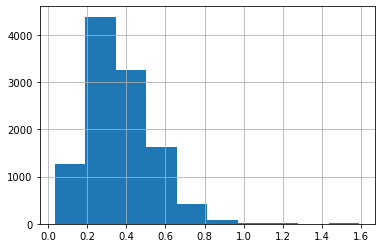

In [15]:
data_with_cost['markup'].hist()

# Q3 BLP

# First we generate an income distribution using the quantile data from the excel file
# For each market, we create 10000 individuals and allocate them into the income bins with the probability provided.
# For each individual, we similuate and income according to her income bin using a uniform distribution.
# Before 1990, I assign the income distribution of 1990.

# I expand the set of characteristics by interacting horsepower and fuel  horsepower and weight  width and height, width and height and weight, I use two sets of instruments.
# 1) Hausman instruments based on product characteristics (average characteristics of the same products in other markets) - the relevance comes from characteristics specific cost shocks
# 2) Differentiation instruments based on product characteristics (function of characteristics of the other products in the same markets)- the relevance comes from competition

In [16]:
blp_results = pset.run_blp_excercise()

market share assumption is 1.1
demand_instruments0 contains missing values, NaNs or infinities.
orginal shape (11483, 39)
after dropping missing or nan or infinities shape (11069, 39)
no variation in demand_instruments9
no variation in demand_instruments20
FE type is product_ids+market_ids


<ipython-input-4-3928b51e759f>:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[f'demand_instruments{next+i}'] = (dataset.groupby(['model','year'])[f'{char}'].transform('sum') - dataset[f'{char}'])/(dataset.groupby(['model','year'])[f'{char}'].transform('count')-1)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]
Initializing the problem ...
Absorbing demand-side fixed effects ...
Initialized the problem after 00:00:03.

Dimensions:
 T    N     F     I     K1    K2    D    MD    ED 
---  ----  ---  -----  ----  ----  ---  ----  ----
104  7814  37   10400   7     2     1    15    2  

Formulations:
       Column Indices:             0          1          2        3      4      5       6   
-----------------------------  ----------  --------  ----------  ----  -----  ------  ------
 X1: Linear Characteristics      prices    domestic  horsepower  fuel  width  height  weight
X2: Nonlinear Characteristics      1        prices                                          
       d: Demographics         log_income                                                   
Solving the problem ...

Nonlinear Coefficient Initial Values:
Sigma:        1           prices      |  Sigma Squared:        1          

                Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
                =========================================================================================================================
                Sigma:         1             prices       |  Sigma Squared:         1             prices       |   Pi:      log_income   
                ------  ---------------  ---------------  |  --------------  ---------------  ---------------  |  ------  ---------------
                1      +2.361008E+01                    |        1          +5.574361E+02    +2.132579E+00   |    1      +3.670867E+01 
                        (+2.252693E+02)                   |                  (+1.063726E+04)  (+1.987785E+01)  |          (+3.368333E+02)
                                                        |                                                    |                         
                prices   +9.032494E-02    +3.188831E-03   |      prices       +2.132579E+00    +8.168763E-03   |  prices   +2.085254E-02 
                        (+3.376249E-02)  (+5.791531E-02)  |                  (+1.987785E+01)  (+5.932895E-03)  |          (+9.209625E-03)
                =========================================================================================================================

                Beta Estimates (Robust SEs in Parentheses):
                =====================================================================================================================
                prices          domestic        horsepower          fuel             width           height           weight     
                ---------------  ---------------  ---------------  ---------------  ---------------  ---------------  ---------------
                -2.842751E-01    +1.864608E+00    +2.479840E-03    -9.474389E-02    +6.497660E-02    +2.438601E-02    +2.524898E-03 
                (+1.122502E-01)  (+2.651746E-02)  (+9.525952E-03)  (+1.764972E-02)  (+6.814699E-03)  (+7.721679E-03)  (+5.831541E-04)
                =====================================================================================================================


# I report the elasticity matrix here. I do not find a lot of heterogeneity in cross price elasticities, because my income preference heterogeneity estimate is very small.
# Italy

In [17]:
blp_results[0][1][(blp_results[0][1].market_ids == 'Italy_1990')&(blp_results[0][1].brand =='Fiat')][['model','price']]

,model,price
7503,fiat 126,5.865586
7515,fiat panda,7.151021
7532,fiat uno,8.716412
7540,fiat tipo,13.207448
7546,fiat tempra,14.458414
7560,fiat regata,13.295722
7565,fiat croma,19.655642


In [18]:
blp_results[1]['Italy_1990']

,fiat 126,fiat panda,fiat uno,fiat tipo,fiat tempra,fiat regata,fiat croma,renault 4,renault 5,renault 19,renault 21,renault 25
model,,,,,,,,,,,,
fiat 126,-3.203614,0.060079,0.047264,0.067991,0.000786,0.020442,0.026947,0.041323,0.023004,0.013629,0.013406,0.134161
fiat panda,0.090217,-3.598127,0.057900,0.067358,0.000985,0.021043,0.036027,0.032861,0.021029,0.016875,0.009898,0.102250
fiat uno,0.070602,0.057597,-3.645681,0.059202,0.001235,0.019678,0.048727,0.019599,0.016141,0.020798,0.005114,0.056221
fiat tipo,0.093121,0.061436,0.054281,-3.495303,0.000917,0.020926,0.032815,0.035773,0.021791,0.015764,0.011066,0.113015
fiat tempra,0.067234,0.056120,0.070683,0.057245,-3.665458,0.019179,0.049282,0.017973,0.015332,0.020932,0.004592,0.050948
fiat regata,0.090084,0.061752,0.058051,0.067328,0.000988,-3.642323,0.036165,0.032737,0.020994,0.016921,0.009849,0.101797
fiat croma,0.056302,0.050128,0.068154,0.050059,0.001204,0.017147,-3.370273,0.013479,0.012743,0.020223,0.003232,0.036874
renault 4,0.103230,0.054667,0.032777,0.065248,0.000525,0.018558,0.016116,-2.295284,0.024713,0.009288,0.019091,0.183416
renault 5,0.098194,0.059777,0.046126,0.067915,0.000765,0.020336,0.026035,0.042229,-3.225426,0.013285,0.013803,0.137690


# Belgium

In [19]:
blp_results[1]['Belgium_1990']

,fiat 126,fiat panda,fiat uno,fiat tipo,fiat tempra,fiat regata,fiat croma,renault 4,renault 5,renault 19,renault 21,renault 25
model,,,,,,,,,,,,
fiat 126,-3.685930,0.010008,0.008591,0.128256,0.048499,0.052390,0.040605,0.005459,0.066240,0.109028,0.062224,0.002017
fiat panda,0.019396,-4.225712,0.011060,0.128405,0.052996,0.053716,0.058045,0.003972,0.051783,0.099312,0.070917,0.002252
fiat uno,0.012074,0.008020,-4.349152,0.104500,0.052463,0.046133,0.103062,0.001436,0.022872,0.064851,0.077067,0.002337
fiat tipo,0.019278,0.009959,0.011176,-4.125659,0.053163,0.053730,0.058934,0.003909,0.051139,0.098798,0.071276,0.002261
fiat tempra,0.017082,0.009631,0.013147,0.124571,-4.425524,0.053143,0.075090,0.002904,0.040466,0.088970,0.076429,0.002386
fiat regata,0.018710,0.009898,0.011723,0.127660,0.053885,-4.278623,0.063189,0.003620,0.048154,0.096308,0.072883,0.002302
fiat croma,0.008384,0.006184,0.015142,0.080961,0.044023,0.036535,-3.666034,0.000789,0.013753,0.045926,0.067142,0.001998
renault 4,0.024930,0.009361,0.004665,0.118775,0.037649,0.046295,0.017459,-1.922653,0.096271,0.120705,0.044191,0.001498
renault 5,0.023983,0.009674,0.005892,0.123183,0.041599,0.048820,0.024115,0.007632,-2.597799,0.117588,0.050447,0.001682


# Mark Ups are shown here

<AxesSubplot:>

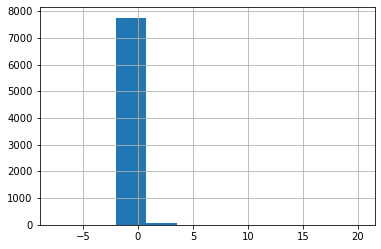

In [20]:
blp_results[0][1]['markup'] = (blp_results[0][1].prices-blp_results[0][1].mc)/blp_results[0][1].prices
blp_results[0][1]['markup'].hist()

# Merger Simulation
# After the merger, we generally see an increase in markups in Renault and Fiat Cars. The increase in markup is larger for Renault (Fiat) models in Italy (Belgium). This increase in markup is associated with a loss in market share.
# Logit

In [21]:
logit_data = result[0]['FE=product_ids+market_ids, IV=blp, Market Share Assumption=1.1'][1]
logit_data['merger_ids'] = logit_data['brand'].replace('Renault', 'Fiat')
logit_data['mc'] = result[0]['FE=product_ids+market_ids, IV=blp, Market Share Assumption=1.1'][0].compute_costs()
logit_data['markup'] = (logit_data['prices']-logit_data['mc'])/logit_data['prices']
logit_data['new_prices'] = result[0]['FE=product_ids+market_ids, IV=blp, Market Share Assumption=1.1'][0].compute_prices(
    firm_ids=logit_data['merger_ids'],
    costs=logit_data['mc']
)
changed_shares = result[0]['FE=product_ids+market_ids, IV=blp, Market Share Assumption=1.1'][0].compute_shares(logit_data['new_prices'])
logit_data['new_shares'] = changed_shares
logit_data['delta_share'] = logit_data['new_shares'] - logit_data['shares']
logit_data['new_markup'] = (logit_data['new_prices']-logit_data['mc'])/logit_data['new_prices']
logit_data['detla_markup'] = logit_data['new_markup'] - logit_data['markup']


Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:01.

Computing shares ...
Finished after 00:00:00.



In [22]:
logit_data[((logit_data.market_ids == 'Italy_1990')|(logit_data.market_ids == 'Belgium_1990'))
           &((logit_data.brand == 'Renault')|(logit_data.brand == 'Fiat'))][['country','brand','model',
                                                                             'shares','new_shares','delta_share',
                                                                             'markup','new_markup','detla_markup']]

,country,brand,model,shares,new_shares,delta_share,markup,new_markup,detla_markup
378,Belgium,Fiat,fiat 126,0.000406,0.000366,-0.000039,0.310445,0.332348,0.021904
389,Belgium,Fiat,fiat panda,0.003510,0.003169,-0.000340,0.261317,0.281168,0.019851
406,Belgium,Fiat,fiat uno,0.014374,0.012980,-0.001394,0.217398,0.234974,0.017576
413,Belgium,Fiat,fiat tipo,0.010806,0.009758,-0.001048,0.147230,0.160295,0.013065
419,Belgium,Fiat,fiat tempra,0.001586,0.001432,-0.000154,0.130910,0.142770,0.011859
432,Belgium,Fiat,fiat regata,0.000141,0.000127,-0.000014,0.144106,0.156944,0.012839
437,Belgium,Fiat,fiat croma,0.002606,0.002353,-0.000253,0.106734,0.116698,0.009963
1466,Belgium,Renault,renault 4,0.001538,0.001496,-0.000042,0.224310,0.229747,0.005437
1484,Belgium,Renault,renault 5,0.026444,0.025724,-0.000720,0.211769,0.216987,0.005218
1488,Belgium,Renault,renault 19,0.041748,0.040612,-0.001137,0.160652,0.164874,0.004222


In [23]:
nlogit_data = nlogit_result[0]['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1'][1]
nlogit_data['merger_ids'] = nlogit_data['brand'].replace('Renault', 'Fiat')
nlogit_data['mc'] = nlogit_result[0]['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1'][0].compute_costs()
nlogit_data['markup'] = (nlogit_data['prices']-nlogit_data['mc'])/nlogit_data['prices']
nlogit_data['new_prices'] = nlogit_result[0]['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1'][0].compute_prices(
    firm_ids=nlogit_data['merger_ids'],
    costs=nlogit_data['mc']
)
nlogit_data['new_shares'] = nlogit_result[0]['FE=product_ids+market_ids, IV=blp, nest=segment, nest_instrument=nest_both, Market Share Assumption=1.1'][0].compute_shares(nlogit_data['new_prices'])
nlogit_data['delta_share'] = nlogit_data['new_shares'] - nlogit_data['shares']
nlogit_data['new_markup'] = (nlogit_data['new_prices']-nlogit_data['mc'])/nlogit_data['new_prices']
nlogit_data['detla_markup'] = nlogit_data['new_markup'] - nlogit_data['markup']

Computing marginal costs ...
Finished after 00:00:00.

Solving for equilibrium prices ...
Finished after 00:00:01.

Computing shares ...
Finished after 00:00:00.



In [24]:
nlogit_data[((nlogit_data.market_ids == 'Italy_1990')|(nlogit_data.market_ids == 'Belgium_1990'))
           &((nlogit_data.brand == 'Renault')|(nlogit_data.brand == 'Fiat'))][['country','brand','model',
                                                                             'shares','new_shares','delta_share',
                                                                             'markup','new_markup','detla_markup']]

,country,brand,model,shares,new_shares,delta_share,markup,new_markup,detla_markup
378,Belgium,Fiat,fiat 126,0.000406,0.000365,-0.000041,0.890699,0.900425,0.009727
389,Belgium,Fiat,fiat panda,0.003510,0.003159,-0.000351,0.749746,0.768760,0.019014
406,Belgium,Fiat,fiat uno,0.014374,0.012937,-0.001438,0.623738,0.647829,0.024091
413,Belgium,Fiat,fiat tipo,0.010806,0.009679,-0.001127,0.418613,0.445151,0.026538
419,Belgium,Fiat,fiat tempra,0.001586,0.001437,-0.000149,0.370076,0.393127,0.023051
432,Belgium,Fiat,fiat regata,0.000141,0.000127,-0.000013,0.407378,0.431162,0.023784
437,Belgium,Fiat,fiat croma,0.002606,0.002337,-0.000269,0.303464,0.326559,0.023095
1466,Belgium,Renault,renault 4,0.001538,0.001484,-0.000054,0.640384,0.649441,0.009057
1484,Belgium,Renault,renault 5,0.026444,0.025514,-0.000930,0.604581,0.613996,0.009415
1488,Belgium,Renault,renault 19,0.041748,0.040625,-0.001124,0.460242,0.467991,0.007749
